# Collimator Detection

This method detects the presence of a collimator be looking at changes in row and column intensities in the image. The two largest gradient changes are taken (the largest second derivative peaks) in the rows and columns. These are used to draw a rectangle isolating the region of interest.

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
import peakutils
from PIL import Image
import rasterio

## Load in image

In [49]:
directory = '/media/sf_TestImageDataBase/RAW_processed_images/labeled/TIF_Images/JPEG_Images/left_fractured_wrist_thusday27_asg.jpg'

In [50]:
img = Image.open(directory)

Implement a rotation and crop down artificial boudary

In [51]:
rotation = 0

In [52]:
img = img.rotate(rotation)
img.save('rotated.jpg')

In [53]:
img = cv.imread('rotated.jpg')
#img = img[400:2400,500:2700]

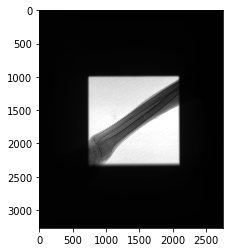

In [54]:
plt.imshow(img)
plt.show()

In [55]:
height,width,depth= img.shape

Implememnt a roatation detection using Canny edge and HoughLines

In [56]:
edges = cv.Canny(img, 0, 70, 1)

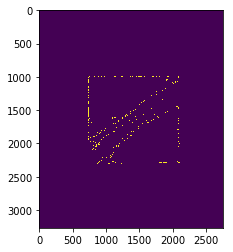

In [57]:
plt.imshow(edges)
plt.show()

In [58]:
cp2 = np.copy(img)

In [59]:
lines = cv.HoughLines(edges,10,np.pi/180,1)

rho, theta = lines[0][0]

In [60]:
gradient = np.sin(theta)/np.cos(theta)
x = np.linspace(0,-width,width)
y = gradient*x

Plot HoughLine output for visual comparison

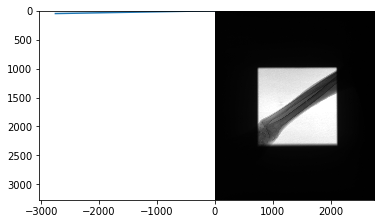

In [61]:
plt.imshow(cp2)
plt.plot(x,y)
plt.show()

Rotate image back

In [62]:
angle = theta*(180/np.pi)

In [63]:
img = Image.open(directory)

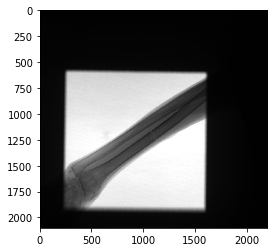

In [64]:
img = img.rotate(rotation)
img = img.rotate(angle+180)
img.save('rotated.jpg')
img = cv.imread('rotated.jpg')
img = img[400:2500,500:2700]
plt.imshow(img)
plt.show()

# Is the image collimated?

In [65]:
def dark(image):
    '''
    Checks image borders for dark pixels (with an RGB value of less than 20).
    Calculates the ratio of dark pixels to total pixels in border region.
    '''
    height,width,depth = image.shape
    num_dark_left = np.count_nonzero(image[:,0:width/10] < [20])/3
    num_dark_right = np.count_nonzero(image[:,-width/10:width] < [20])/3
    num_dark_top = np.count_nonzero(image[0:height/10,:] < [20])/3
    num_dark_bottom = np.count_nonzero(image[-height/10:height,:] < [20])/3
    num_dark = num_dark_left+num_dark_right+num_dark_bottom+num_dark_top
    
    total = (width/10)*height*2 + (height/10)*width*2
    
    return (float(num_dark)/float(total))

Increase contrast of image on a copy

In [66]:
cp = np.copy(img)
cp[cp<100] = 1
cp[cp>150] = 255

In [67]:
ratio = dark(cp)
ratio

0.978413961038961

Decide if image is collimated

In [68]:
if ratio > 0.6:
    print ('image is collimated')
else:
    print ('image is not collimated')

image is collimated


## Average over intensities

In [69]:
height,width,depth= img.shape

### Iterate over width

In [70]:
tot_avg_width = np.array([])
for i in range(width):
    avg = np.average(img[:,i])
    
    tot_avg_width = np.append(tot_avg_width,avg)
    
x_width = np.arange(0,width)

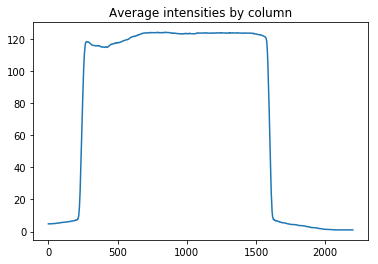

In [71]:
plt.plot(x_width,tot_avg_width)
plt.title('Average intensities by column')
plt.show()

Smooth and take the second derivative

In [72]:
y_width = savgol_filter(tot_avg_width, window_length=101, polyorder=2, deriv=2) 

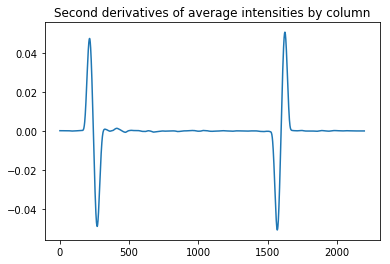

In [73]:
plt.plot(x_width,y_width)
plt.title('Second derivatives of average intensities by column')
plt.show()

### Iterate over height

In [74]:
tot_avg_height = np.array([])
for i in range(height):
    avger = np.average(img[i,:])
    
    tot_avg_height = np.append(tot_avg_height,avger)
    
x_height = np.arange(0,height) 

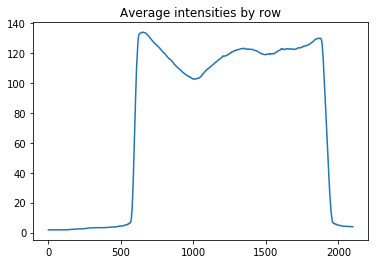

In [75]:
plt.plot(x_height,tot_avg_height)
plt.title('Average intensities by row')
plt.show()

Smooth and take second derivative

In [76]:
y_height = savgol_filter(tot_avg_height, window_length=101, polyorder=2, deriv=2) 

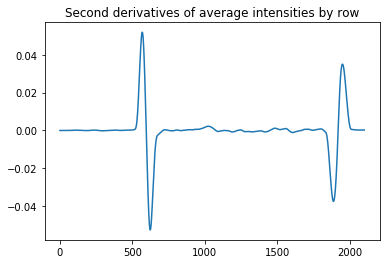

In [77]:
plt.plot(x_height,y_height)
plt.title('Second derivatives of average intensities by row')
plt.show()

# If Collimated -> detect

## Peak detection

In [78]:
peakfind_width = peakutils.indexes(y_width, thres=0.1, min_dist=500)
peakfind_height = peakutils.indexes(y_height, thres=0.1, min_dist=500)

In [79]:
peaks_width = y_width[peakfind_width]
peaks_height = y_height[peakfind_height]
print (peaks_width)

[4.75421967e-02 2.56379379e-04 5.07285343e-02 7.81998735e-07]


In [80]:
sorted_width = np.argsort(peaks_width)
two_max_width = sorted_width[::-1][:2]

sorted_height = np.argsort(peaks_height)
two_max_height = sorted_height[::-1][:2]
print (peakfind_width[two_max_width])

[1625  214]


In [81]:
line3 = np.linspace(peakfind_width[two_max_width[0]],peakfind_width[two_max_width[0]],height)
line4 = np.linspace(peakfind_width[two_max_width[1]],peakfind_width[two_max_width[1]],height)

x2 = np.linspace(0,height,height)

line1 = np.linspace(peakfind_height[two_max_height[0]],peakfind_height[two_max_height[0]],width)
line2 = np.linspace(peakfind_height[two_max_height[1]],peakfind_height[two_max_height[1]],width)

x1 = np.linspace(0,width,width)

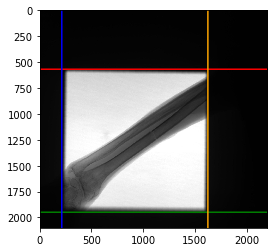

In [82]:
plt.plot(x1,line1, color = 'red')
plt.plot(x1,line2, color = 'green')
plt.plot(line3,x2, color = 'orange')
plt.plot(line4,x2, color = 'blue')
plt.imshow(img)
plt.show()

## Crop Image

In [83]:
tl = [int(line4[0]),int(line1[0])]
tr = [int(line3[0]),int(line1[0])]
bl = [int(line4[0]),int(line2[0])]
br = [int(line3[0]),int(line2[0])]

x_corners = np.array([int(line4[0]),int(line3[0])])
y_corners = np.array([int(line2[0]),int(line1[1])])

In [84]:
crop = img[np.min(y_corners)+50:np.max(y_corners)-50,np.min(x_corners)+50:np.max(x_corners)-50]

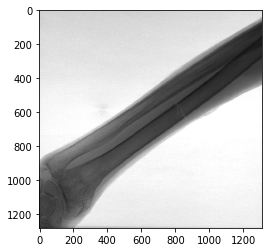

In [85]:
plt.imshow(crop)
plt.show()